In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.initializers import Orthogonal
import keras
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [6]:
DATA_PATH = '../'
df_train = pd.read_csv(DATA_PATH + 'PM_train.csv')
df_test = pd.read_csv(DATA_PATH + 'PM_test.csv')
df_truth = pd.read_csv(DATA_PATH + 'PM_truth.csv')

In [7]:
df_train.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739  
4  38.90  23.4044  

[5 rows x 26 columns]

In [8]:
df_test.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21   
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42   
2   1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94  1401.34   
3   1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12  1406.42   
4   1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19  1401.92   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0   
1  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0   
2  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388  100.0   
3  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388  100.0   
4  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388  100.0   

     s20      s21  
0  38.86  23.3735  
1  39.02  23.3916  
2  39.08  23.4166  
3  39.00  23.3737  
4  38.99  23.4130  

[5 rows x 26 columns]

In [9]:
df_truth.head()

id  cycle
0   1    112
1   2     98
2   3     69
3   4     82
4   5     91

In [10]:
for i in range(1, 101):
    max_rul = df_train[df_train['id'] == i]['cycle'].max()
    df_train.loc[df_train['id'] == i, 'RUL'] = df_train[df_train['id'] == i]['cycle'].apply(lambda x: max_rul - x)

In [11]:
# Define window values
w0, w1 = 15, 30

# Create label1 for training data
df_train['label1'] = np.where(df_train['RUL'] <= w1, 1, 0)

# Create label2 for training data
df_train['label2'] = np.where(df_train['RUL'] > w1,
                              0,
                              np.where((df_train['RUL'] <= w1) & (df_train['RUL'] > w0),
                                      1, 2))

In [12]:
def normalize_data(df, col_not_to_norm):
    columns_to_normalize = df.columns.difference(col_not_to_norm)

    # Separate the columns
    df_to_normalize = df[columns_to_normalize]
    df_not_to_normalize = df[col_not_to_norm]

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the data
    normalized_df = pd.DataFrame(scaler.fit_transform(df_to_normalize), columns=columns_to_normalize)

    return pd.concat([df_not_to_normalize, normalized_df], axis=1)

In [13]:
columns_not_to_normalize = ['id', 'cycle', 'RUL', 'label1', 'label2']
df_train = normalize_data(df_train, columns_not_to_normalize)
df_train.head()

id  cycle    RUL  label1  label2   s1  s10       s11       s12       s13  \
0   1      1  191.0       0       0  0.0  0.0 -0.266467  0.334262 -1.058890   
1   1      2  190.0       0       0  0.0  0.0 -0.191583  1.174899 -0.363646   
2   1      3  189.0       0       0  0.0  0.0 -1.015303  1.364721 -0.919841   
3   1      4  188.0       0       0  0.0  0.0 -1.539489  1.961302 -0.224597   
4   1      5  187.0       0       0  0.0  0.0 -0.977861  1.052871 -0.780793   

   ...        s3        s4            s5        s6        s7        s8  \
0  ... -0.134255 -0.925936 -1.776357e-15  0.141683  1.121141 -0.516338   
1  ...  0.211528 -0.643726 -1.776357e-15  0.141683  0.431930 -0.798093   
2  ... -0.413166 -0.525953 -1.776357e-15  0.141683  1.008155 -0.234584   
3  ... -1.261314 -0.784831 -1.776357e-15  0.141683  1.222827  0.188048   
4  ... -1.251528 -0.301518 -1.776357e-15  0.141683  0.714393 -0.516338   

         s9  setting1  setting2  setting3  
0 -0.862813 -0.315980 -1.372953       0.0  
1 -0.958818  0.872722 -1.031720       0.0  
2 -0.557139 -1.961874  1.015677       0.0  
3 -0.713826  0.324090 -0.008022       0.0  
4 -0.457059 -0.864611 -0.690488       0.0  

[5 rows x 29 columns]

In [14]:
# Combine test and truth data
df_test = pd.merge(df_test, df_truth.rename(columns={'cycle': 'RUL'}), on=['id'], how='left')

# create RUL column
df_test['RUL'] = df_test['RUL'] - df_test['cycle']

# Create label1 for training data
df_test['label1'] = np.where(df_test['RUL'] <= w1, 1, 0)

# Create label2 for training data
df_test['label2'] = np.where(df_test['RUL'] > w1,
                              0,
                              np.where((df_test['RUL'] <= w1) & (df_test['RUL'] > w0),
                                      1, 2))

# Normalize data
df_test = normalize_data(df_test, columns_not_to_normalize)
df_test.head()

id  cycle  RUL  label1  label2   s1           s10       s11       s12  \
0   1      1  111       0       0  0.0 -2.220446e-16 -1.103591 -0.049542   
1   1      2  110       0       0  0.0 -2.220446e-16  0.427727  0.736727   
2   1      3  109       0       0  0.0 -2.220446e-16  0.427727  0.397202   
3   1      4  108       0       0  0.0 -2.220446e-16 -0.695239 -0.657113   
4   1      5  107       0       0  0.0 -2.220446e-16 -0.542108  0.718857   

        s13  ...        s3        s4            s5       s6        s7  \
0 -0.720590  ... -0.561495 -0.975674 -1.776357e-15  0.17566  0.209138   
1 -0.193647  ...  0.070116 -1.392836 -1.776357e-15  0.17566  1.603612   
2 -0.720590  ... -0.231698 -0.507676 -1.776357e-15  0.17566  0.517390   
3 -0.369295  ... -0.795350  0.251888 -1.776357e-15  0.17566  0.458675   
4 -0.720590  ... -0.181729 -0.420954 -1.776357e-15  0.17566  0.590783   

         s8        s9  setting1  setting2  setting3  
0 -0.539078 -0.720312  1.049295  1.005927       0.0  
1 -1.061366 -0.348673 -1.220748 -1.034755       0.0  
2 -0.364982 -0.126564  0.141278  0.325700       0.0  
3 -0.713174 -1.147041  1.911912 -0.014414       0.0  
4 -1.061366 -1.211750  0.640688 -0.014414       0.0  

[5 rows x 29 columns]

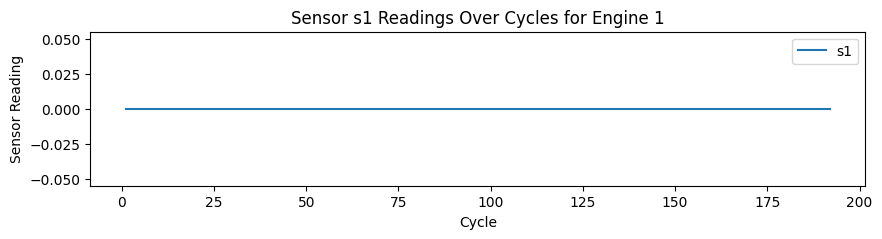

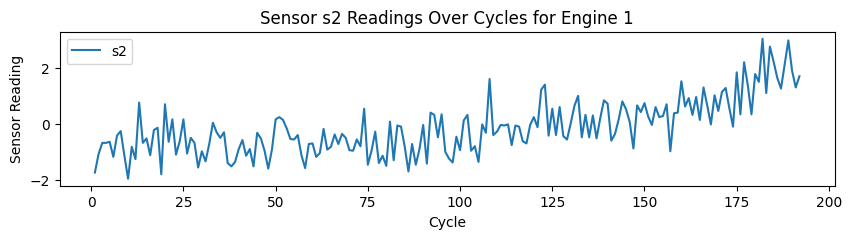

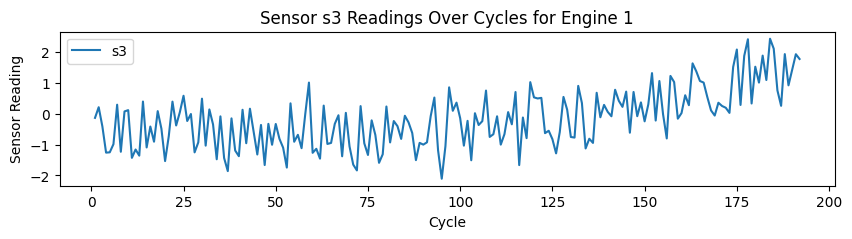

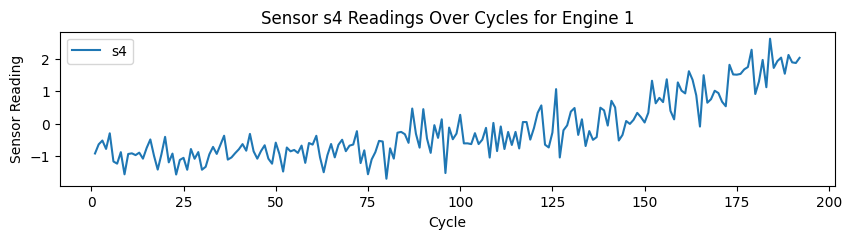

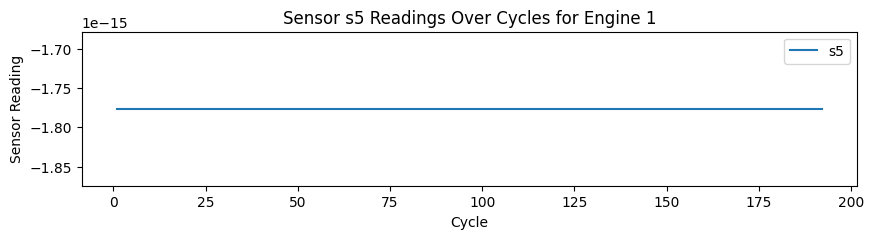

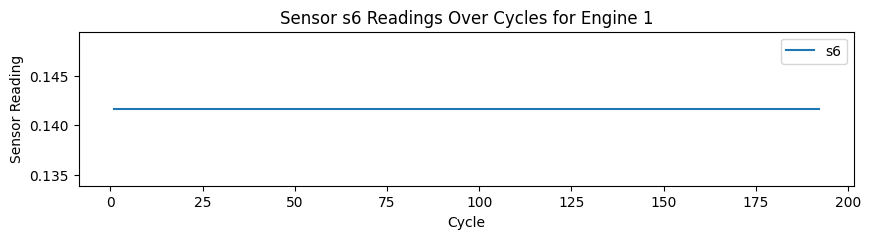

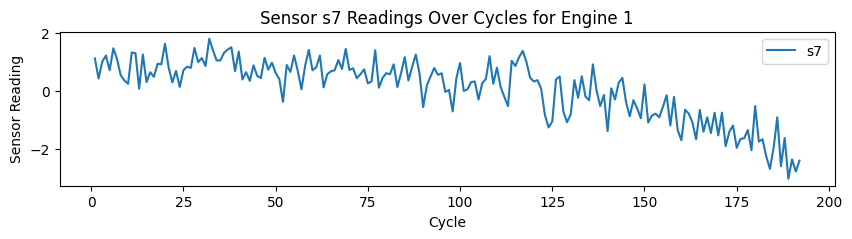

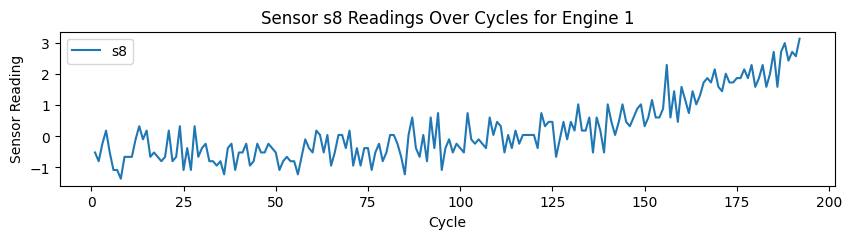

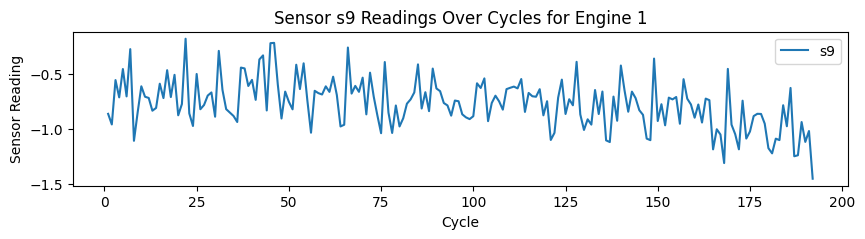

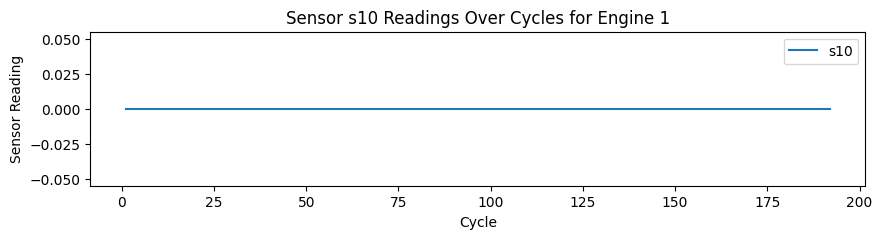

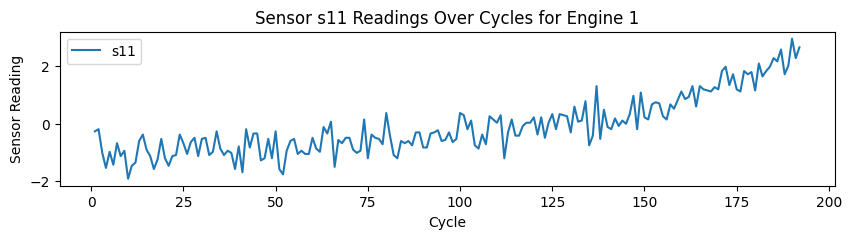

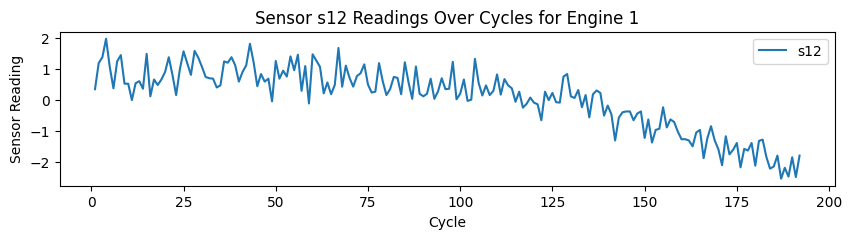

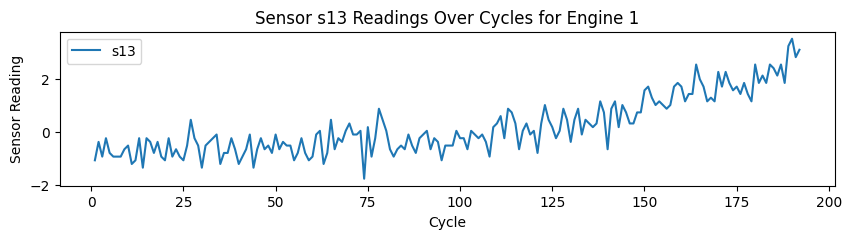

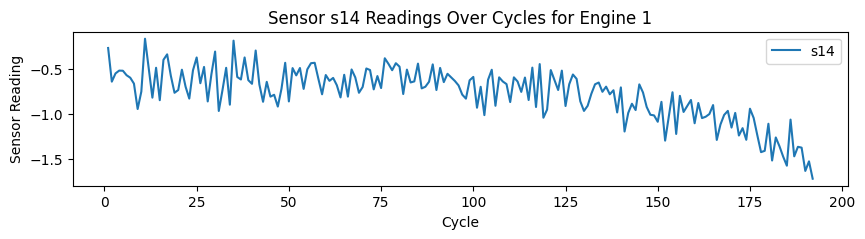

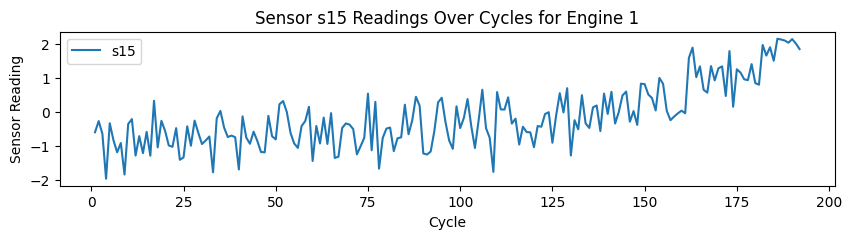

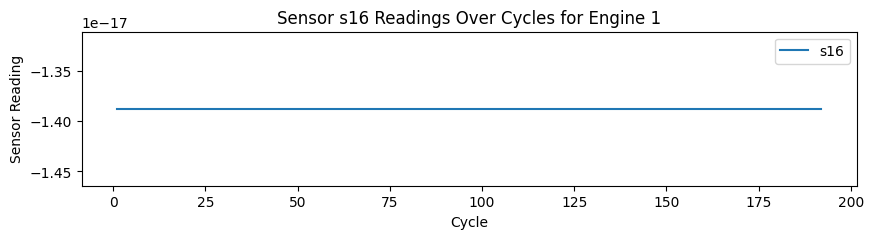

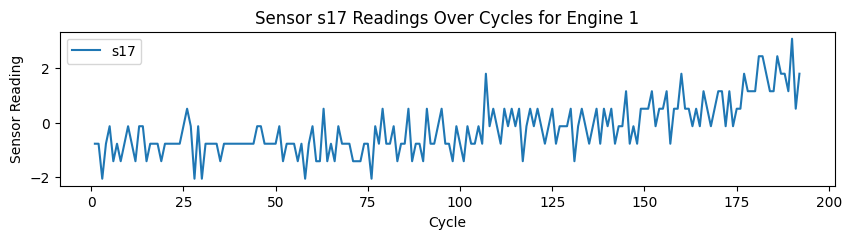

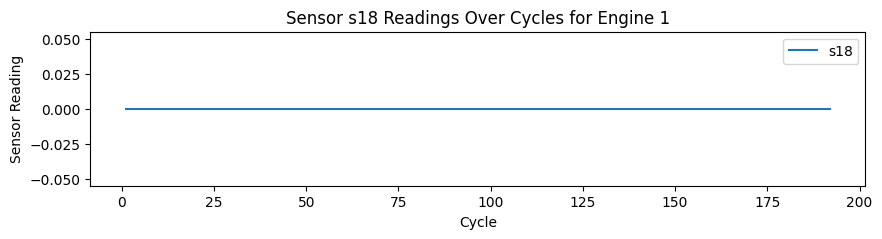

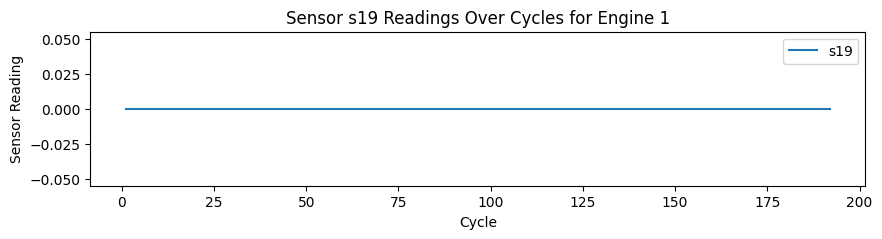

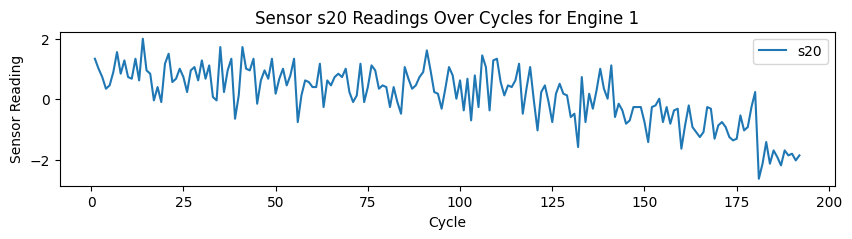

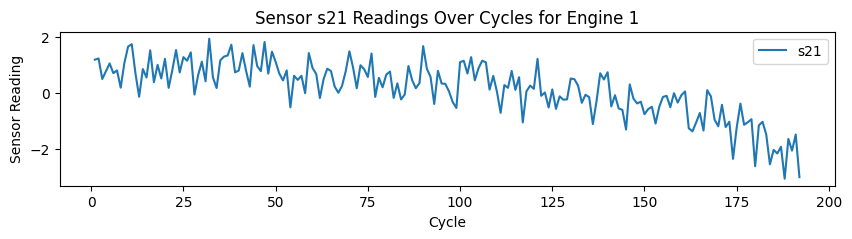

In [15]:
# Select the engine ID
engine_id = 1

# Filter the dataframe for the selected engine
engine_data = df_train[df_train['id'] == engine_id]

# List of sensors to plot
sensors = [f's{i}' for i in range(1, 22)]

# Plot each sensor reading over cycles in separate graphs
for sensor in sensors:
    plt.figure(figsize=(10, 2))
    plt.plot(engine_data['cycle'], engine_data[sensor], label=sensor)
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Reading')
    plt.title(f'Sensor {sensor} Readings Over Cycles for Engine 1')
    plt.legend()
    plt.show()

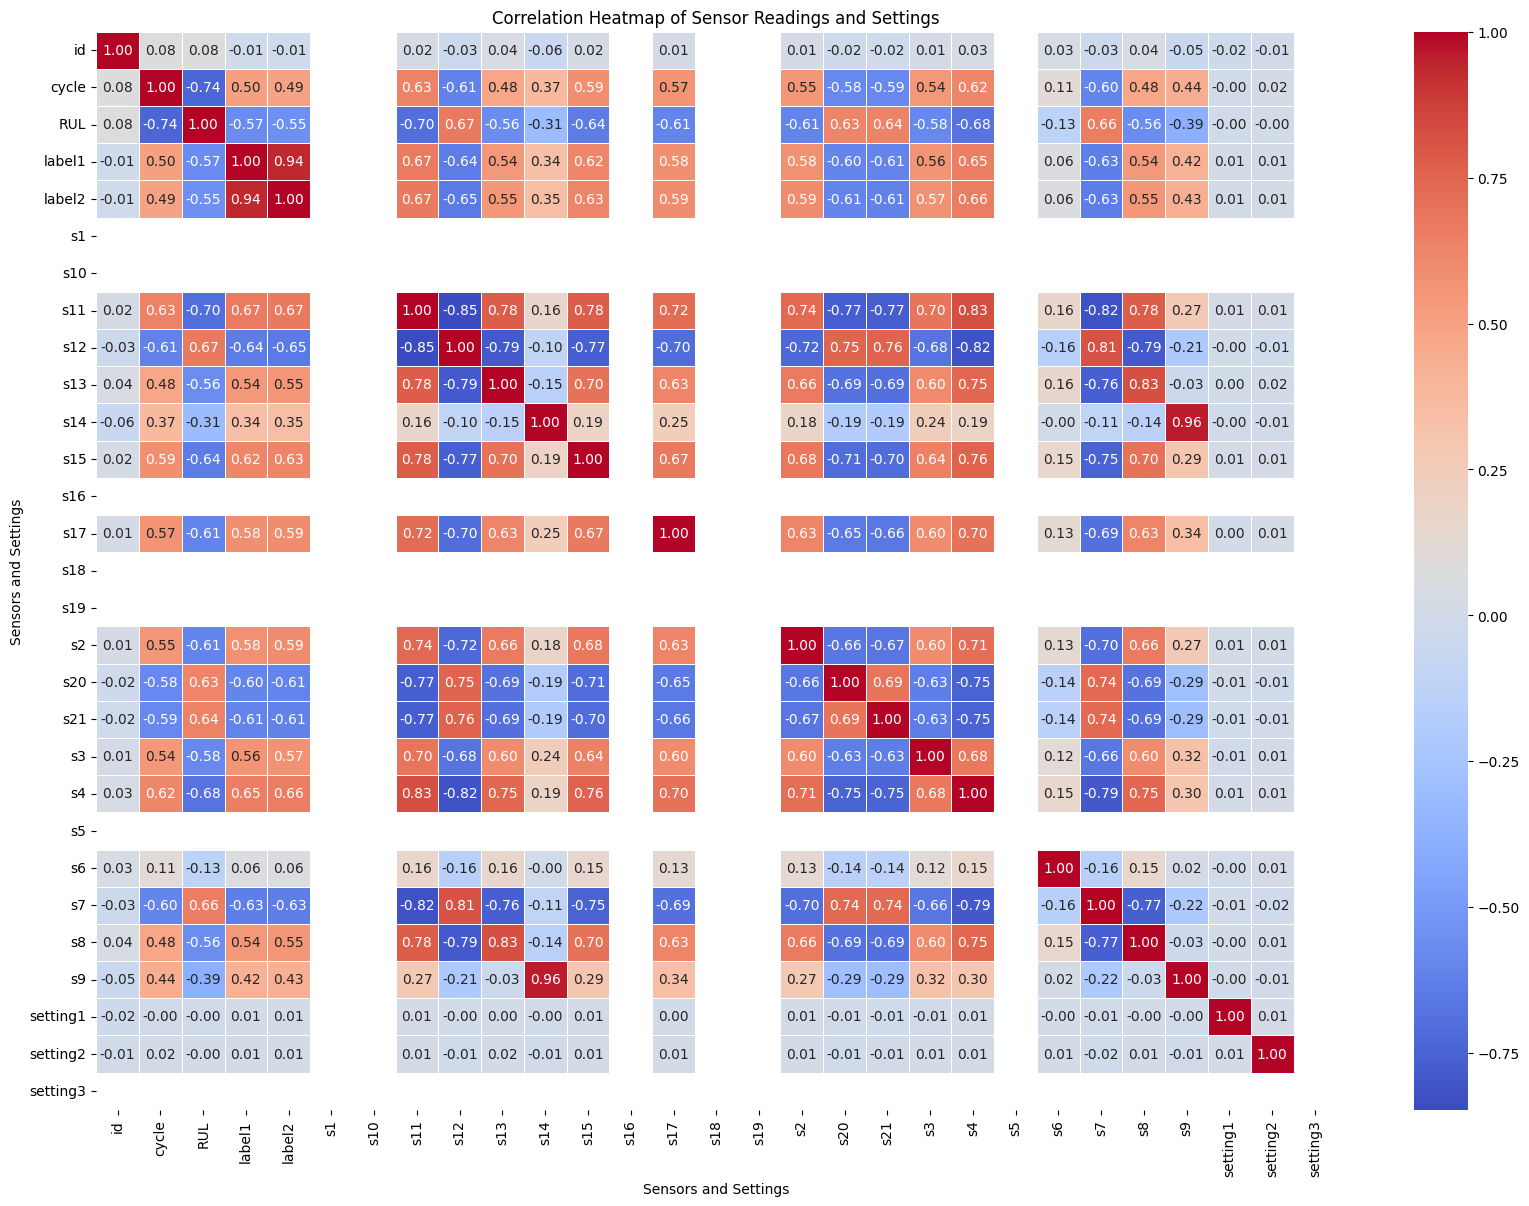

In [16]:
# Calculate the correlation matrix
correlation_matrix = df_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 14))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)

# Add titles and labels
plt.title('Correlation Heatmap of Sensor Readings and Settings')
plt.xlabel('Sensors and Settings')
plt.ylabel('Sensors and Settings')

# Show the heatmap
plt.show()

In [17]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [18]:
# pick the feature columns
sequence_cols = ['setting1', 'setting2', 'setting3']
key_cols = ['id', 'cycle']
label_cols = ['label1', 'label2', 'RUL']

input_features = df_test.columns.values.tolist()
sensor_cols = [x for x in input_features if x not in set(key_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(label_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(sequence_cols)]

# The time is sequenced along
# This may be a silly way to get these column names, but it's relatively clear
sequence_cols.extend(sensor_cols)

print(sequence_cols)

['setting1', 'setting2', 'setting3', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7', 's8', 's9']


In [19]:
# generator for the sequences
seq_gen = (list(gen_sequence(df_train[df_train['id']==id], sequence_length, sequence_cols))
           for id in df_train['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(df_train[df_train['id']==id], sequence_length, ['label1'])
             for id in df_train['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [21]:
# build the network
# Feature weights
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# GRU model
model = Sequential()
model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True,
         recurrent_initializer=Orthogonal(gain=1.0, seed=None)))

model.add(Dropout(0.2))

model.add(GRU(
          units=50,
          return_sequences=False,
          recurrent_initializer=Orthogonal(gain=1.0, seed=None)))

model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Verify the architecture
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 50, 100)             │          37,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,651 (236.92 KB)

 Trainable params: 60,651 (236.92 KB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
# Fit the network
model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=200, #
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                   min_delta=0,    # until it doesn't change (or gets worse)
                                                   patience=5,  # patience > 1 so it continues if it is not consistently improving
                                                   verbose=0,
                                                   mode='auto')])

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.8140 - loss: 0.3727 - val_accuracy: 0.9329 - val_loss: 0.1507
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.9570 - loss: 0.1095 - val_accuracy: 0.9527 - val_loss: 0.1025
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.9649 - loss: 0.0796 - val_accuracy: 0.9636 - val_loss: 0.0754
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step - accuracy: 0.9737 - loss: 0.0659 - val_accuracy: 0.9469 - val_loss: 0.1404
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - accuracy: 0.9735 - loss: 0.0631 - val_accuracy: 0.9687 - val_loss: 0.0691
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.9739 - loss: 0.0596 - val_accuracy: 0.9623 - val_loss: 0.0905
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.9814 - loss: 0.0476 - val_accuracy: 0.9636 - val_loss: 0.0866
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - accuracy: 0.9851 - loss: 0.0384 - val_accu

In [23]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Training Accurracy: {}'.format(scores[1]))

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9914 - loss: 0.0207
Training Accurracy: 0.9876527190208435


489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step


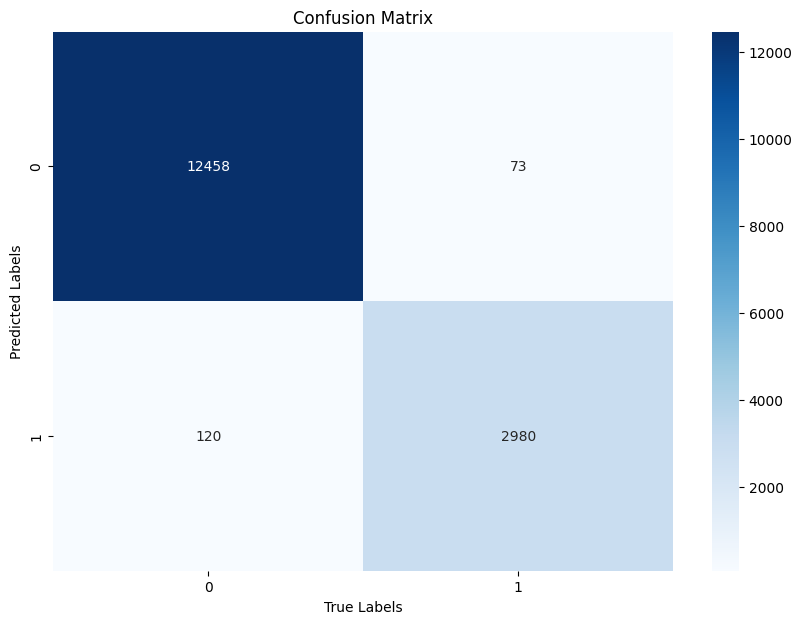

Training Precision:  0.9760890926957091
Training Recall:  0.9612903225806452
Training F1 Score: 0.9686331870632212


In [24]:
# Make predictions
y_pred = (model.predict(seq_array) > 0.5).astype("int32")
y_true = label_array

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)

print('Training Precision: ', precision)
print('Training Recall: ', recall)
print('Training F1 Score:', f1)

In [25]:
# Select the last sequence for each engine ID in the test data
seq_array_test_last = [
    df_test[df_test['id'] == id][sequence_cols].values[-sequence_length:]
    for id in df_test['id'].unique() if len(df_test[df_test['id'] == id]) >= sequence_length
]

# Convert the list to a numpy array and ensure the data type is float32
seq_array_test_last = np.array(seq_array_test_last, dtype=np.float32)
seq_array_test_last.shape

(93, 50, 24)

In [26]:
# Create a mask to filter engine IDs with enough data points
y_mask = [len(df_test[df_test['id'] == id]) >= sequence_length for id in df_test['id'].unique()]

# Extract the last label for each engine ID that meets the sequence length requirement
label_array_test_last = df_test.groupby('id')['label1'].nth(-1)[y_mask].values

# Reshape and convert to float32
label_array_test_last = label_array_test_last.reshape(-1, 1).astype(np.float32)

# Display shapes of the test sequences and labels
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 24)
(93, 1)


In [27]:
# Evaluate the model on the test data
test_scores = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
test_accuracy = test_scores[1]

# Print and log the test accuracy
print(f'Test Accuracy: {test_accuracy}')

3/3 - 0s - 45ms/step - accuracy: 0.5161 - loss: 3.9646
Test Accuracy: 0.5161290168762207


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


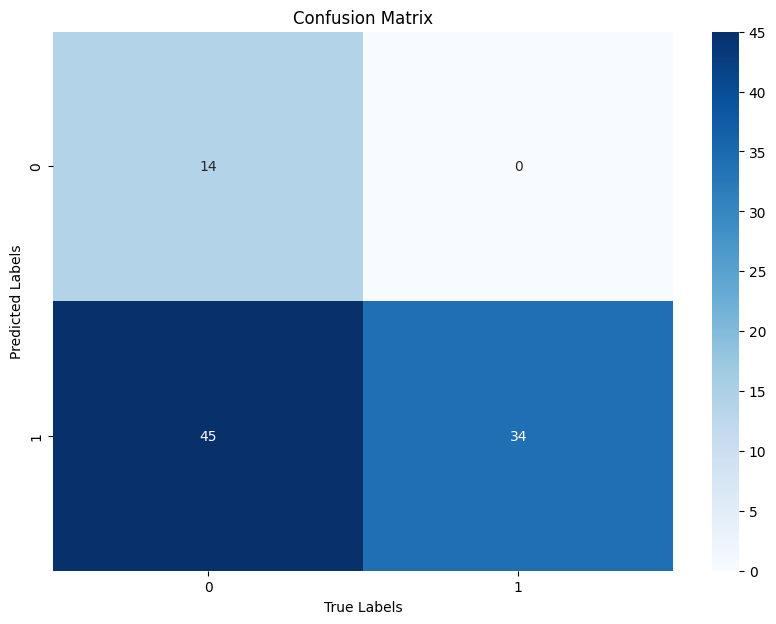

Training Precision:  1.0
Training Recall:  0.43037974683544306
Training F1 Score: 0.6017699115044248


In [28]:
# Make predictions
y_test_pred = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_test_true = label_array_test_last

# Compute confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 score
precision = precision_score(y_test_true, y_test_pred)
recall = recall_score(y_test_true, y_test_pred)
f1 = 2 * (precision * recall) / (precision + recall)

print('Training Precision: ', precision)
print('Training Recall: ', recall)
print('Training F1 Score:', f1)